Generating environment...

=== Running pure GA ===
[ga] Gen 0: best fitness = 46526.7207
[ga] Gen 10: best fitness = 46439.4206
[ga] Gen 20: best fitness = 46439.4206
[ga] Gen 30: best fitness = 46439.4206
[ga] Gen 40: best fitness = 46439.4206
[ga] Gen 50: best fitness = 46439.4206
[ga] Gen 60: best fitness = 46424.3965
[ga] Gen 70: best fitness = 46424.3965
[ga] Gen 79: best fitness = 46424.3965
GA result: fitness=46424.3965  total_time=653.5s  total_energy=19.5626  penalty=5002800.0  benefit=37.1061

=== Running Hybrid (GA + per-UAV 2-opt) ===
[hybrid] Gen 0: best fitness = 46564.5816
[hybrid] Gen 10: best fitness = 46461.7514
[hybrid] Gen 20: best fitness = 46461.7514
[hybrid] Gen 30: best fitness = 46461.7514
[hybrid] Gen 40: best fitness = 46461.7514
[hybrid] Gen 50: best fitness = 46461.7514
[hybrid] Gen 60: best fitness = 46451.3709
[hybrid] Gen 70: best fitness = 46451.3709
[hybrid] Gen 79: best fitness = 46445.6745
Hybrid result: fitness=46445.6745  total_time=669.3s  total_e

/tmp/ipython-input-2049858509.py:402: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab20', len(uavs))


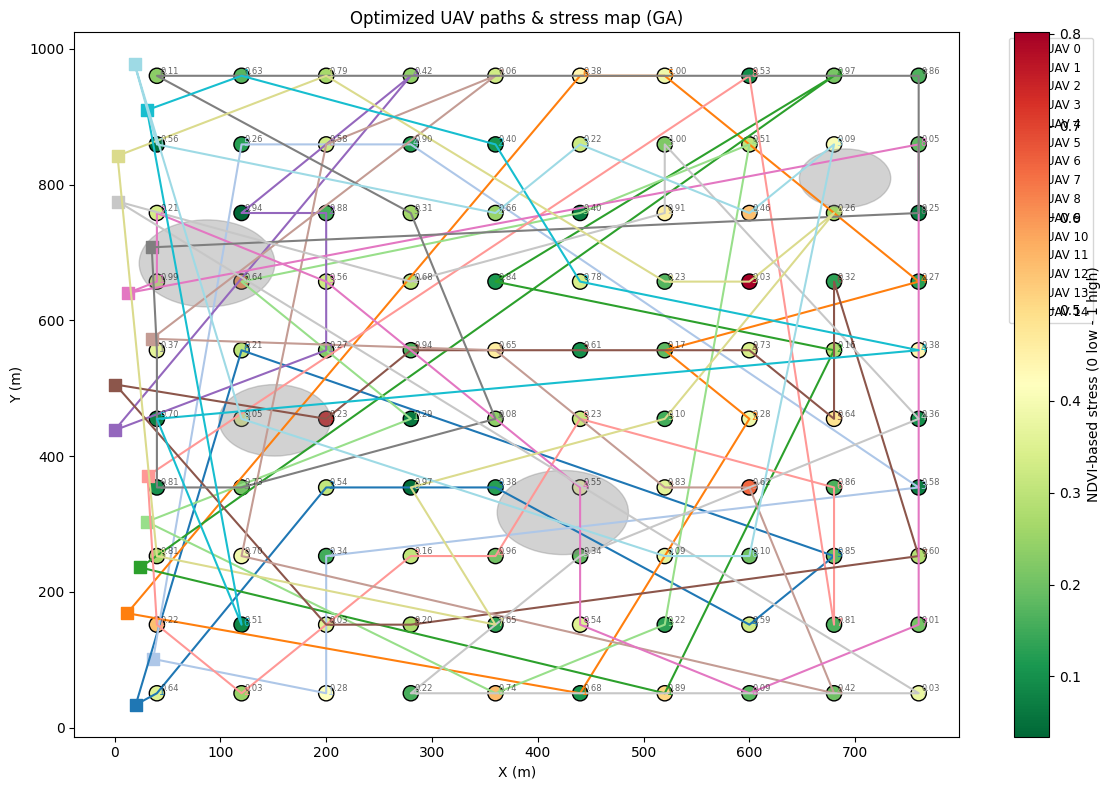

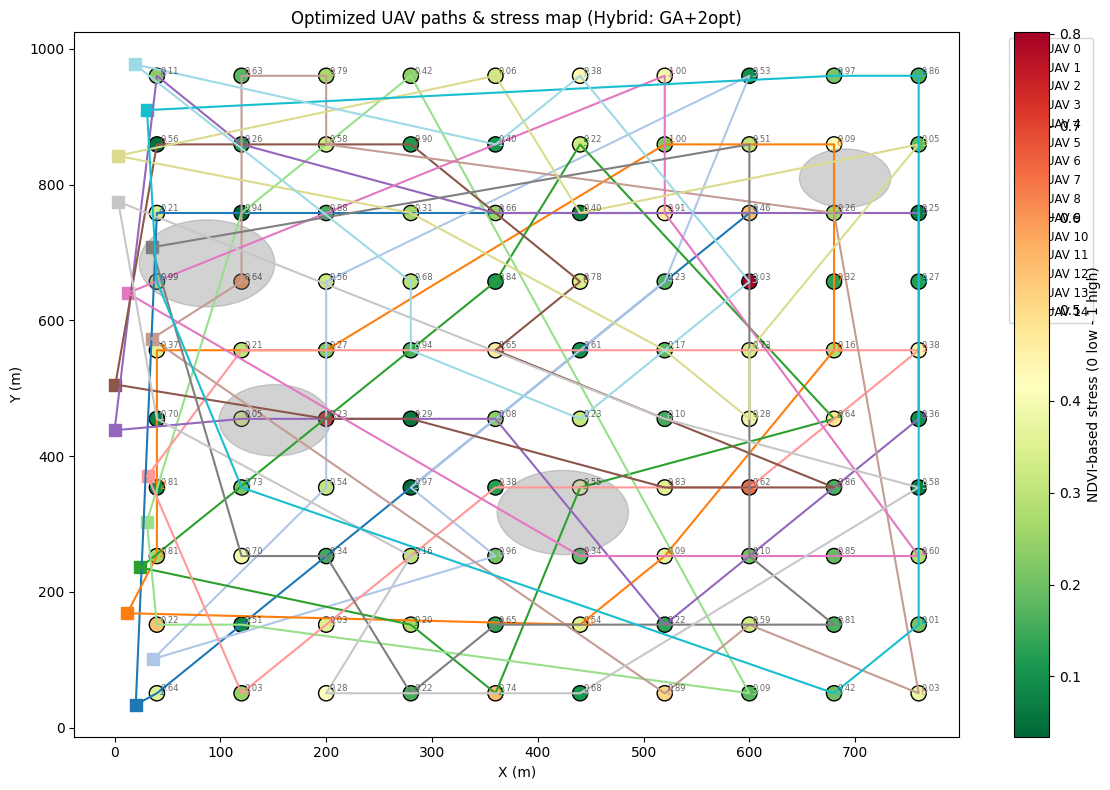


Saved 'zone_allocation_ga.csv' and 'zone_allocation_hybrid.csv' in current directory.

Done.


In [2]:
"""
Precision Crop-Health Monitoring — GA vs Hybrid (GA + 2-opt) comparison
- Implements continuous priority [0,1] -> affects scan time and fitness.
- Two modes: 'ga' (pure GA) and 'hybrid' (GA + per-UAV 2-opt local search).
- Outputs: zone allocation table, optimized paths plot, fitness & summary.

Requirements: Python 3.8+, numpy, pandas, matplotlib
Run: python uav_swarm_compare.py
"""

import math
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import copy
import time

# ---------------------------
# PARAMETERS (tweak these)
# ---------------------------
SEED = 42
random.seed(SEED)
np.random.seed(SEED)

FARM_ACRES = 200
ACRE_M2 = 4046.86
FARM_AREA_M2 = FARM_ACRES * ACRE_M2
FARM_WIDTH = 800.0   # meters
FARM_HEIGHT = int(FARM_AREA_M2 / FARM_WIDTH)

GRID_ROWS = 10
GRID_COLS = 10
NUM_ZONES = GRID_ROWS * GRID_COLS

NUM_UAVS = 15
UAV_SPEED = 10.0         # m/s
ENERGY_PER_M = 0.0005    # abstract battery units per meter
MIN_SEPARATION = 20.0    # meters
COLLISION_TIME_WINDOW = 15.0  # seconds
SCAN_BASE = 30.0         # base scan time (seconds)

# priority distribution options: 'uniform', 'beta', 'normal'
PRIORITY_DISTRIBUTION = 'uniform'
BETA_A, BETA_B = 2.0, 2.0
NORMAL_MEAN, NORMAL_STD = 0.5, 0.18

# GA hyperparameters
POP_SIZE = 60
GENERATIONS = 80
CROSSOVER_RATE = 0.8
MUTATION_RATE = 0.20
TOURNAMENT_K = 3

# fitness weighting
BENEFIT_WEIGHT = 120.0    # larger -> stronger incentive to collect high-priority zones early
PRIORITY_ALPHA = 2.0      # used in zone_value_for_fitness
NO_FLY_ZONE_PENALTY = 1e6
COLLISION_PENALTY = 200.0
MISSED_BATTERY_PENALTY = 200.0

# choose mode: 'ga' or 'hybrid'
MODE = 'hybrid'   # change to 'ga' to run pure GA

# ---------------------------
# Helper math / gen funcs
# ---------------------------

def euclid(a, b):
    return math.hypot(a[0]-b[0], a[1]-b[1])

def gen_priority():
    if PRIORITY_DISTRIBUTION == 'uniform':
        return random.random()
    elif PRIORITY_DISTRIBUTION == 'beta':
        return float(np.clip(np.random.beta(BETA_A, BETA_B), 0.0, 1.0))
    elif PRIORITY_DISTRIBUTION == 'normal':
        return float(np.clip(np.random.normal(NORMAL_MEAN, NORMAL_STD), 0.0, 1.0))
    else:
        return random.random()

def scan_time_for_priority(priority, base=SCAN_BASE, factor=1.0):
    # soft scaling: higher priority -> longer scan (more thorough)
    return base * (1.0 + factor * priority)

def zone_value_for_fitness(stress, priority, alpha=PRIORITY_ALPHA):
    # base value is stress (NDVI-based), amplified by priority
    return stress * (1.0 + alpha * priority)

# ---------------------------
# Environment generation
# ---------------------------

def generate_zones(rows, cols, width, height):
    zones = []
    dx = width / cols
    dy = height / rows
    idc = 0
    for r in range(rows):
        for c in range(cols):
            cx = (c + 0.5) * dx
            cy = (r + 0.5) * dy
            stress = float(np.clip(np.random.beta(2,5), 0, 1))
            priority = gen_priority()
            zones.append({
                'zone_id': idc,
                'x': cx,
                'y': cy,
                'stress': stress,
                'priority': priority,
            })
            idc += 1
    return zones

def generate_no_fly_zones(width, height, count=3):
    zones = []
    for i in range(count):
        cx = random.uniform(0.1*width, 0.9*width)
        cy = random.uniform(0.1*height, 0.9*height)
        r = random.uniform(30, 80)
        zones.append((cx, cy, r))
    return zones

def zone_in_no_fly(zone, nfz_list):
    for (cx, cy, r) in nfz_list:
        if euclid((zone['x'], zone['y']), (cx, cy)) <= r:
            return True
    return False

# ---------------------------
# UAV fleet
# ---------------------------

def generate_uavs(num_uavs, width, height):
    uavs = []
    # place bases evenly along left edge
    for i in range(num_uavs):
        base_x = random.uniform(0.0, 40.0)
        base_y = (i + 0.5) * (height / max(1, num_uavs))
        battery = random.uniform(0.6, 1.0)  # abstract battery units
        uavs.append({'uav_id': i, 'base': (base_x, base_y), 'battery': battery})
    return uavs

# ---------------------------
# Route utils (greedy ordering + 2-opt)
# ---------------------------

def greedy_order(zlist, zones, start_pos):
    if not zlist:
        return []
    remaining = set(zlist)
    current = start_pos
    order = []
    while remaining:
        nearest = min(remaining, key=lambda z: euclid((zones[z]['x'], zones[z]['y']), current))
        order.append(nearest)
        current = (zones[nearest]['x'], zones[nearest]['y'])
        remaining.remove(nearest)
    return order

def route_distance(order, zones, start_pos):
    if not order:
        return 0.0
    dist = 0.0
    prev = start_pos
    for zid in order:
        cur = (zones[zid]['x'], zones[zid]['y'])
        dist += euclid(prev, cur)
        prev = cur
    dist += euclid(prev, start_pos)  # return to base
    return dist

def two_opt(route, zones, start_pos, time_budget=0.005):
    # classic 2-opt improvement for a single route (returns improved route)
    # time_budget in seconds to prevent excessive runtimes per route
    start_time = time.time()
    best = route[:]
    improved = True
    while improved and (time.time() - start_time) < time_budget:
        improved = False
        n = len(best)
        if n < 3:
            break
        for i in range(0, n-2):
            for j in range(i+2, n):
                # reverse segment i+1..j
                new_route = best[:i+1] + list(reversed(best[i+1:j+1])) + best[j+1:]
                if route_distance(new_route, zones, start_pos) + 1e-9 < route_distance(best, zones, start_pos):
                    best = new_route
                    improved = True
                    break
            if improved:
                break
    return best

# ---------------------------
# Encoding + GA operators
# Individual: list length NUM_ZONES with value in [0..NUM_UAVS-1]
# ---------------------------

def random_individual(num_zones, num_uavs):
    # produce roughly balanced random assignment
    # we may bias toward assigning each UAV roughly equal number of zones
    assign = [random.randrange(num_uavs) for _ in range(num_zones)]
    return assign

def decode_routes(assign, zones, uavs, apply_2opt=False):
    per_uav = defaultdict(list)
    for zid, uav_id in enumerate(assign):
        per_uav[uav_id].append(zid)
    routes = {}
    for uav in uavs:
        uid = uav['uav_id']
        zlist = per_uav.get(uid, [])
        order = greedy_order(zlist, zones, uav['base'])
        if apply_2opt and order:
            order = two_opt(order, zones, uav['base'])
        routes[uid] = order
    return routes

def crossover(a, b):
    n = len(a)
    if n < 2:
        return a[:], b[:]
    pt = random.randint(1, n-1)
    ca = a[:pt] + b[pt:]
    cb = b[:pt] + a[pt:]
    return ca, cb

def mutate(indiv, num_uavs, mut_rate=MUTATION_RATE):
    out = indiv[:]
    for i in range(len(out)):
        if random.random() < mut_rate:
            out[i] = random.randrange(num_uavs)
    return out

def tournament(pop, scores, k=TOURNAMENT_K):
    selected = random.sample(range(len(pop)), k)
    best = min(selected, key=lambda idx: scores[idx])
    return pop[best]

# ---------------------------
# Fitness evaluation
# - We compute for each UAV the timeline of visits (time, x, y, zid)
# - Total_time is makespan (max UAV time)
# - Total_energy is sum of energy used
# - Benefit: summed zone value discounted by visit time -> reward early coverage of high-priority zones
# - Penalties: no-fly zone violation, battery insufficiency, collisions
# ---------------------------

def evaluate(assign, zones, uavs, nfz_list, apply_2opt=False):
    routes = decode_routes(assign, zones, uavs, apply_2opt)
    timelines = {}
    total_time = 0.0
    total_energy = 0.0
    penalty = 0.0
    benefit = 0.0

    # per-uav simulation
    for uav in uavs:
        uid = uav['uav_id']
        path = routes.get(uid, [])
        t = 0.0
        pos = uav['base']
        energy_used = 0.0
        timeline = []
        for order_idx, zid in enumerate(path):
            z = zones[zid]
            # check no-fly
            if zone_in_no_fly(z, nfz_list):
                penalty += NO_FLY_ZONE_PENALTY
            dist = euclid(pos, (z['x'], z['y']))
            travel_time = dist / UAV_SPEED
            t += travel_time
            energy_used += dist * ENERGY_PER_M
            stime = scan_time_for_priority(z['priority'])
            t += stime
            # benefit: zone value discounted by visit time (earlier -> larger)
            value = zone_value_for_fitness(z['stress'], z['priority'])
            # discount: 1/(1 + t/discount_scale), discount_scale in seconds (e.g., 600s = 10min)
            discount = 1.0 / (1.0 + (t / 600.0))
            benefit += value * discount
            timeline.append((t, z['x'], z['y'], zid))
            pos = (z['x'], z['y'])
        # return to base
        dist = euclid(pos, uav['base'])
        travel_time = dist / UAV_SPEED
        t += travel_time
        energy_used += dist * ENERGY_PER_M
        timelines[uid] = timeline
        total_time = max(total_time, t)
        total_energy += energy_used

        # battery check (simple): if estimated energy > battery -> penalty
        if energy_used > uav['battery']:
            penalty += MISSED_BATTERY_PENALTY

    # collision detection (pairwise)
    uav_ids = list(timelines.keys())
    for i in range(len(uav_ids)):
        for j in range(i+1, len(uav_ids)):
            tl1 = timelines[uav_ids[i]]
            tl2 = timelines[uav_ids[j]]
            for t1, x1, y1, zid1 in tl1:
                for t2, x2, y2, zid2 in tl2:
                    if abs(t1 - t2) <= COLLISION_TIME_WINDOW:
                        if euclid((x1,y1),(x2,y2)) < MIN_SEPARATION:
                            penalty += COLLISION_PENALTY

    # final fitness: lower is better
    fitness = total_time + 10.0 * total_energy + 0.01 * penalty - BENEFIT_WEIGHT * benefit
    # ensure fitness is not negative crazy
    fitness = float(fitness)
    summary = {
        'fitness': fitness,
        'total_time': total_time,
        'total_energy': total_energy,
        'penalty': penalty,
        'benefit': benefit,
        'timelines': timelines,
        'routes': routes
    }
    return fitness, summary

# ---------------------------
# GA main
# ---------------------------

def run_ga(zones, uavs, nfz_list, mode='ga'):
    apply_2opt = (mode == 'hybrid')
    pop = [random_individual(len(zones), len(uavs)) for _ in range(POP_SIZE)]
    best = None
    best_score = float('inf')
    history = []

    for gen in range(GENERATIONS):
        scores = []
        for indiv in pop:
            sc, _ = evaluate(indiv, zones, uavs, nfz_list, apply_2opt=apply_2opt)
            scores.append(sc)
            if sc < best_score:
                best_score = sc
                best = indiv[:]
        history.append(best_score)
        if gen % 10 == 0 or gen == GENERATIONS - 1:
            print(f"[{mode}] Gen {gen}: best fitness = {best_score:.4f}")

        newpop = []
        while len(newpop) < POP_SIZE:
            parent1 = tournament(pop, scores)
            parent2 = tournament(pop, scores)
            if random.random() < CROSSOVER_RATE:
                child1, child2 = crossover(parent1, parent2)
            else:
                child1, child2 = parent1[:], parent2[:]
            child1 = mutate(child1, len(uavs))
            child2 = mutate(child2, len(uavs))
            newpop.append(child1)
            if len(newpop) < POP_SIZE:
                newpop.append(child2)
        pop = newpop

    best_score, best_summary = evaluate(best, zones, uavs, nfz_list, apply_2opt=apply_2opt)
    return best, best_score, best_summary, history

# ---------------------------
# Visualization and outputs
# ---------------------------

def build_zone_table(zones, best_assign):
    data = []
    for z in zones:
        data.append({
            'zone_id': z['zone_id'],
            'x': z['x'],
            'y': z['y'],
            'stress': z['stress'],
            'priority': z['priority'],
            'assigned_uav': int(best_assign[z['zone_id']])
        })
    df = pd.DataFrame(data)
    return df

def plot_solution(zones, uavs, nfz_list, best_assign, summary, title_suffix='', filename=None):
    routes = summary['routes']
    plt.figure(figsize=(12,8))
    xs = [z['x'] for z in zones]
    ys = [z['y'] for z in zones]
    stresses = [z['stress'] for z in zones]
    prios = [z['priority'] for z in zones]
    sc = plt.scatter(xs, ys, c=stresses, cmap='RdYlGn_r', s=120, edgecolor='k')
    plt.colorbar(sc, label='NDVI-based stress (0 low - 1 high)')
    # overlay priority as texts (small)
    for z in zones:
        plt.text(z['x']+3, z['y']+3, f"{z['priority']:.2f}", fontsize=6, alpha=0.6)

    for (cx, cy, r) in nfz_list:
        c = plt.Circle((cx, cy), r, color='gray', alpha=0.35)
        plt.gca().add_patch(c)

    colors = plt.cm.get_cmap('tab20', len(uavs))
    for uav in uavs:
        uid = uav['uav_id']
        bx, by = uav['base']
        plt.scatter([bx], [by], marker='s', s=80, color=colors(uid), label=f'UAV {uid}')
        path = routes.get(uid, [])
        if path:
            px = [bx] + [zones[z]['x'] for z in path] + [bx]
            py = [by] + [zones[z]['y'] for z in path] + [by]
            plt.plot(px, py, linestyle='-', linewidth=1.5, color=colors(uid))
            for order_idx, zid in enumerate(path):
                plt.text(zones[zid]['x']+2, zones[zid]['y']-2, str(order_idx+1), fontsize=7, color=colors(uid))

    plt.title(f"Optimized UAV paths & stress map {title_suffix}")
    plt.xlabel('X (m)')
    plt.ylabel('Y (m)')
    plt.legend(bbox_to_anchor=(1.05,1), loc='upper left', fontsize='small')
    plt.tight_layout()
    if filename:
        plt.savefig(filename, dpi=200)
    plt.show()

# ---------------------------
# Demo run
# ---------------------------

def main():
    print("Generating environment...")
    zones = generate_zones(GRID_ROWS, GRID_COLS, FARM_WIDTH, FARM_HEIGHT)
    nfz_list = generate_no_fly_zones(FARM_WIDTH, FARM_HEIGHT, count=4)
    # small tweak: bump stress for zones inside nfz to simulate anomalies
    for z in zones:
        if zone_in_no_fly(z, nfz_list):
            z['stress'] = min(1.0, z['stress'] + 0.2)

    uavs = generate_uavs(NUM_UAVS, FARM_WIDTH, FARM_HEIGHT)

    # Run GA-only
    print("\n=== Running pure GA ===")
    best_ga_assign, best_ga_score, best_ga_summary, hist_ga = run_ga(zones, uavs, nfz_list, mode='ga')
    print("GA result: fitness=%.4f  total_time=%.1fs  total_energy=%.4f  penalty=%.1f  benefit=%.4f" %
          (best_ga_score, best_ga_summary['total_time'], best_ga_summary['total_energy'], best_ga_summary['penalty'], best_ga_summary['benefit']))

    # Run Hybrid (GA + 2-opt)
    print("\n=== Running Hybrid (GA + per-UAV 2-opt) ===")
    best_h_assign, best_h_score, best_h_summary, hist_h = run_ga(zones, uavs, nfz_list, mode='hybrid')
    print("Hybrid result: fitness=%.4f  total_time=%.1fs  total_energy=%.4f  penalty=%.1f  benefit=%.4f" %
          (best_h_score, best_h_summary['total_time'], best_h_summary['total_energy'], best_h_summary['penalty'], best_h_summary['benefit']))

    # Build tables + plots
    df_ga = build_zone_table(zones, best_ga_assign)
    df_h = build_zone_table(zones, best_h_assign)

    print("\nTop 12 zone assignments (GA):")
    print(df_ga.head(12).to_string(index=False))

    print("\nTop 12 zone assignments (Hybrid):")
    print(df_h.head(12).to_string(index=False))

    # Plot both solutions side-by-side
    plot_solution(zones, uavs, nfz_list, best_ga_assign, best_ga_summary, title_suffix='(GA)')
    plot_solution(zones, uavs, nfz_list, best_h_assign, best_h_summary, title_suffix='(Hybrid: GA+2opt)')

    # Save CSVs
    df_ga.to_csv('zone_allocation_ga.csv', index=False)
    df_h.to_csv('zone_allocation_hybrid.csv', index=False)
    print("\nSaved 'zone_allocation_ga.csv' and 'zone_allocation_hybrid.csv' in current directory.")
    print("\nDone.")

if __name__ == '__main__':
    main()


#### video

In [ ]:
"""
FINAL UAV SIMULATION (PRIORITY-BASED + SCI-FI VISUAL + WORKING MP4 EXPORT)
"""

import math, random, os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.animation import FuncAnimation, FFMpegWriter

# ----------------------------
# PARAMETERS
# ----------------------------
SEED = 1
random.seed(SEED)
np.random.seed(SEED)

GRID_ROWS = 10
GRID_COLS = 20
NUM_ZONES = GRID_ROWS * GRID_COLS

FARM_WIDTH = 100
FARM_HEIGHT = 50
ZONE_W = FARM_WIDTH / GRID_COLS
ZONE_H = FARM_HEIGHT / GRID_ROWS

NUM_UAVS = 15
UAV_SPEED = 0.8
SCAN_TIME_FRAMES = 30
TOTAL_FRAMES = 1200
FPS = 30

OUT_VIDEO = "uav_sci_fi_sim.mp4"

# Styling
BG_COLOR = "#0b0f1a"
NEON_COLORS = plt.cm.tab20.colors
ZONE_CMAP = plt.cm.get_cmap('RdYlGn_r')
TRAIL_LENGTH = 35

# ----------------------------
# Create zones
# ----------------------------
zones = []
for r in range(GRID_ROWS):
    for c in range(GRID_COLS):
        idx = r * GRID_COLS + c
        pr = float(np.clip(np.random.beta(1.8, 2.5), 0.0, 1.0))
        x = c * ZONE_W
        y = r * ZONE_H
        zones.append({
            'zone_id': idx,
            'row': r, 'col': c,
            'x': x, 'y': y,
            'priority': pr,
            'scanned': False,
            'last_scanned_frame': -999
        })

# ----------------------------
# PRIORITY-BASED ASSIGNMENT
# ----------------------------
all_zone_ids = sorted(
    [z['zone_id'] for z in zones],
    key=lambda zid: zones[zid]['priority'],
    reverse=True
)

assignments = [[] for _ in range(NUM_UAVS)]
for i, zid in enumerate(all_zone_ids):
    assignments[i % NUM_UAVS].append(zid)

# ----------------------------
# PRIORITY-AWARE PATH BUILDER
# ----------------------------
def build_path_for_uav(zids):
    if not zids:
        return []

    remaining = zids[:]

    # Start with highest priority
    current = max(remaining, key=lambda zid: zones[zid]['priority'])
    path = [current]
    remaining_set = set(remaining)
    remaining_set.remove(current)

    while remaining_set:
        last = path[-1]
        last_pos = np.array([zones[last]['x']+ZONE_W/2,
                             zones[last]['y']+ZONE_H/2])

        # priority-aware nearest
        nearest = min(
            remaining_set,
            key=lambda z: (0.7 * math.hypot(
                    zones[z]['x']+ZONE_W/2 - last_pos[0],
                    zones[z]['y']+ZONE_H/2 - last_pos[1]
                )
                - 50 * zones[z]['priority'])
        )
        path.append(nearest)
        remaining_set.remove(nearest)

    return path

uav_paths = [build_path_for_uav(lst) for lst in assignments]

# ----------------------------
# Create UAV objects
# ----------------------------
uavs = []
for uid in range(NUM_UAVS):
    base_x = -5.0
    base_y = (uid + 0.5) * (FARM_HEIGHT / NUM_UAVS)

    pos = np.array([base_x, base_y], dtype=float)
    uav = {
        'id': uid,
        'pos': pos,
        'path': uav_paths[uid],
        'target_idx': 0,
        'state': 'to_zone',
        'scan_timer': 0,
        'trail': [],
        'color': NEON_COLORS[uid % len(NEON_COLORS)]
    }
    uavs.append(uav)

# ----------------------------
# Matplotlib Setup
# ----------------------------
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize=(14, 8))
ax.set_facecolor(BG_COLOR)
ax.set_xlim(-10, FARM_WIDTH + 10)
ax.set_ylim(-5, FARM_HEIGHT + 5)
ax.set_aspect('equal')
ax.axis('off')

# Draw zones
zone_patches = []
for z in zones:
    rect = patches.Rectangle(
        (z['x'], z['y']),
        ZONE_W, ZONE_H,
        linewidth=0.5, edgecolor='#142033',
        facecolor=ZONE_CMAP(z['priority'])
    )
    ax.add_patch(rect)
    zone_patches.append(rect)

# UAV visuals
uav_scatters = []
uav_trails = []
uav_glows = []

for uav in uavs:
    sc = ax.scatter([], [], s=120, marker='^', color=uav['color'],
                    edgecolors='white', linewidths=0.6, zorder=5)
    uav_scatters.append(sc)

    trail_line, = ax.plot([], [], linewidth=2.0, alpha=0.9,
                          color=uav['color'], zorder=4)
    uav_trails.append(trail_line)

time_text = ax.text(0.5, 0.98, "", transform=ax.transAxes,
                    ha='center', va='top', color='white', fontsize=14)

# ----------------------------
# Helpers
# ----------------------------
def zone_center(zid):
    z = zones[zid]
    return np.array([z['x'] + ZONE_W/2, z['y'] + ZONE_H/2])

def move_towards(pos, target, speed):
    vec = (target - pos)
    dist = np.linalg.norm(vec)
    if dist < 1e-6:
        return pos.copy(), True
    step = min(speed, dist)
    return pos + (vec/dist) * step, step == dist

# ----------------------------
# Animation update
# ----------------------------
def update(frame):
    sim_seconds = frame / FPS
    time_text.set_text(f"Sim: {sim_seconds:.1f}s")

    # update zones
    for zid, rect in enumerate(zone_patches):
        z = zones[zid]
        base = ZONE_CMAP(z['priority'])
        if (frame - z['last_scanned_frame']) < 8:
            rect.set_facecolor((min(base[0]+0.5,1), min(base[1]+0.5,1),
                                min(base[2]+0.5,1), 0.9))
            rect.set_edgecolor("white")
            rect.set_linewidth(1.5)
        else:
            rect.set_facecolor(base)
            rect.set_edgecolor("#142033")
            rect.set_linewidth(0.5)

    # update UAVs
    for i, u in enumerate(uavs):

        # moving to next zone
        if u['state'] == 'to_zone':
            if u['target_idx'] >= len(u['path']):
                base = np.array([-5.0, (u['id'] + 0.5)*(FARM_HEIGHT/NUM_UAVS)])
                u['pos'], _ = move_towards(u['pos'], base, UAV_SPEED*0.5)
            else:
                zid = u['path'][u['target_idx']]
                tgt = zone_center(zid)
                u['pos'], arrived = move_towards(u['pos'], tgt, UAV_SPEED)
                if arrived:
                    u['state'] = 'scanning'
                    u['scan_timer'] = 0

        # scanning zone
        elif u['state'] == 'scanning':
            u['scan_timer'] += 1
            zid = u['path'][u['target_idx']]

            if u['scan_timer'] == 1:
                zones[zid]['last_scanned_frame'] = frame

                # ----------------------------------------------------
                # OPTION 1 + OPTION 2 PRIORITY UPDATE (THE FIX)
                # ----------------------------------------------------
                old_pr = zones[zid]['priority']

                # Option 1: strong gradual decrease
                zones[zid]['priority'] = old_pr * 0.20

                # Option 2: instant heal if extremely red
                if old_pr >= 0.85:
                    zones[zid]['priority'] = 0.0
                # ----------------------------------------------------

            if u['scan_timer'] >= SCAN_TIME_FRAMES:
                u['target_idx'] += 1
                u['state'] = 'to_zone'

        # draw trail
        u['trail'].append(u['pos'].copy())
        if len(u['trail']) > TRAIL_LENGTH:
            u['trail'].pop(0)

        t = np.array(u['trail'])
        if len(t) > 1:
            uav_trails[i].set_data(t[:, 0], t[:, 1])

        uav_scatters[i].set_offsets(u['pos'])

    return zone_patches + uav_scatters + uav_trails + [time_text]

# ----------------------------
# RUN ANIMATION
# ----------------------------
anim = FuncAnimation(fig, update, frames=TOTAL_FRAMES,
                     interval=1000/FPS, blit=False)

# ----------------------------
# SAVE MP4 CORRECTLY
# ----------------------------
writer = FFMpegWriter(
    fps=FPS,
    codec='libx264',
    bitrate=3000,
    extra_args=['-pix_fmt', 'yuv420p']
)

print("Rendering MP4...")
anim.save(OUT_VIDEO, writer=writer, dpi=150)
print("Saved video:", OUT_VIDEO)

plt.close(fig)


/tmp/ipython-input-3758314815.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  ZONE_CMAP = plt.cm.get_cmap('RdYlGn_r')


Rendering MP4...
